# Improving Hydro Power Plants optimization using the HBV model

In this Notebook we first define the HBV model and the use it to get the inflow of water that goes to the hydro power plant that we are optimising.


## 1. HBV 

We recall the different variables:    
- $a(t)$ the total water runoff on day $t$
- $a_2(t)$ the surface runoff
- $a_1(t)$ the interflow
- $a_0(t)$ the baseflow
- $K_0(t)$ the recession coefficient associated to the surface runflow
- $K_1(t)$ the recession coefficient associated to the inflow
- $a_2(t)$ the recession coefficient associated to the baseflow
- $T$ the last day of the model
- $\tilde{\theta}$ the temperature threshold for the processing of inputed precipitations
- $S_m(t)$ the snow melting rate
- $\theta(t)$ the temperature on day $t$
- $F$ the degree-day factor
- $FC$ the Field Capacity, ie the maximum storable soil moisture
- $SM(t)$ the soil moisture in L
- $P(t)$ the volume of rainfall water in L
- $\beta$ the shape coefficient for the moisture deficit
- $P_{eff}$ the effective precipitation that contributes to the surface runoff
- $\frac{SM(t)}{FC}$ the soil moisture deficit 
- $PE_a(t)$ the daily adjusted potential evapotranspiration
- $\bar{\theta}(t)$ the mean daily temperature
- $\theta_m$ the long term monthly mean temperature
- $PE_m$ the long term monthly mean potential evapotranspiration
- $E_a(t)$ the actual daily evapotranspiration
- $PWP$ the soil Permanent Wilting Point, ie the minimal soil moisture a plant requires not to wilt

In [2]:
import numpy as np
import datetime
from scipy.stats.stats import pearsonr 
import scipy.optimize as sco
import pandas as pd
import matplotlib.pyplot as plt
path = "C:\\Users\\Arthur\\Documents\\Studies\\ParisDauphineUniversity\\Master203\\M2\\alternative finance\\HydroPPandHBV\\"

In [3]:
def module_snowmelting(t, precipitations, temp, snow_pack, rainfall, F=4.5, temp_threshold=0):
    """
    Snow melting module
    
    Returns the amount of rainfall and snow accumulation.
    
    ------------------------------------------------------------
    
    Parameters:
    
    t, date - Running day
    precipitations, array - Expected precipitations for the running period
    temp, array - Expected temperatures for the running period
    snow_pack, array - Amount of snow accumulated
    F, float - Degree-day factor
    temp_threshold, float - Temperature threshold for snow to melt
    
    """

    if temp[t] > temp_threshold:
            # snow melts and precipitations are rainfalls
            rainfall[t] = precipitations[t] + min(F*(temp[t]-temp_threshold) , snow_pack[t-1])
            snow_pack[t] = max(0,snow_pack[t-1] - F*(temp[t]-temp_threshold))
    else:
        # there is no rainfall, precipitations contribute to the snow pack
        snow_pack[t] = snow_pack[t-1] + precipitations[t]
        rainfall[t] = 0

    return rainfall, snow_pack

def module_soilmoisture(t, rainfall, sm, effective_precipitation, FC=1, beta=1):
    """
    Soil moisture module
    
    Returns the updated soil moisture and the effective precipitation that contributes to the runoff.
        
    ------------------------------------------------------------
    
    Parameters:
    
    t, date - Running day
    rainfall, array - Amount of rain and melting snow that goes to the soil
    sm, array - Soil Moisture water amount
    FC, float - Field Capacity, ie maximum storage in the subsurface zone
    beta, positive integer - Shape Coefficient for the contribution to effective runoff
    
    """

    sm[t] = sm[t-1] + rainfall[t] * (1-(sm[t-1]/FC)**beta)
    effective_precipitation[t] = rainfall[t] * (sm[t]/FC)**beta
    
    
    return sm, effective_precipitation

def module_evapotranspiration(t,m, sm, ea, pea, temp,temp_m, pe_m, C=1, PWP=0):
    """
    Evapotranspiration module
    
    Returns the evapotranspiration and the soil moisture
    
    ------------------------------------------------------------
    
    Parameters:
    
    t, date, - Running day
    m, integer between 1 and 12 - Running month
    sm, array - Soil Moisture water amount
    temp, array - Expected temperatures for the running period
    temp_m, array - Long-term monthly mean temperatures
    pe_m, array -  Long-term mean monthly potential evapotranspiration 
    C, float - Model parameter
    PWP, float - Soil Permanent Wilting Poin
    
    """
    
    # compute the daily adjusted potential evapotranspiration

    pea[t] = (1+C * (temp[t]-temp_m[m-1])) * pe_m[m-1]
    
    # computes actual evapotranspiration
    if sm[t-1] < PWP:
        ea[t] = pea[t] * sm[t-1] / PWP
    else:
        ea[t] = pea[t]
    
    sm[t]-=ea[t]
    
    return ea, sm


def module_runoff(t, effective_precipitation, rl, ru1,ru2,ru3, a0, a1, a2,a3,perc, K=[1,1,1]):
    """
    Runoff module
    
    Returns the three runoff discharges.
    
    ------------------------------------------------------------
    
    Parameters:
    
    t, date, - Running day 
    K, array - Recessions coefficients (slow and quick)
    rl, array - Lower reservoir level
    ru1, array - Upper reservoir level
    ru2, array - Upper reservoir level
    ru3, array - Upper reservoir level
    a0, array - Baseflow slow runoff 
    a1, array - Inflow runoff 
    a2, array - Percolation runoff 
    a3, array - Near surface runoff 
    perc, float - Quantity that is percolated from the upper to the lower reservoir
    effective_precipitation, array - Effective contribution to the runoff
    
    """
    
    a0[t] = K[0]*rl[t-1]
    rl[t] = rl[t-1]-a0[t] + effective_precipitation[t]*(1-perc)
    
    
    ru1[t] = max(ru1[t-1] + effective_precipitation[t]*perc - a1[t-1],0)
    ru2[t] = max(a1[t] * K[1] - a2[t-1],0)
    ru3[t] = max(ru3[t-1] + K[1]*a2[t] - a3[t-1],0)
    
    a1[t] = K[1] * ru1[t]
    a2[t] = K[1] * ru2[t]
    a3[t] = K[1] * ru3[t]
    
    return rl, ru1,ru2,ru3, a0, a1, a2,a3

def total_runoff(t, a0,a3,area):
    """
    Returns the total runoff discharge for one day.
    
    ------------------------------------------------------------
        
    Parameters:
    
    t, date, - Running day
    a0, array - Baseflow runoff
    a3, array - Near surface flow runoff
    area, float - Area of the region
    
    """
    
    return 1000* area* (a0[t] + a3[t])/86400

def HBV(days, precipitations, temp, pe_m, temp_m, init):
    
    """
    Returns the total runoff waters for each day.
        
    ------------------------------------------------------------
        
    Parameters:
    
    days, array of dates - Days of the running period
    precipitations, array - Expected precipitations for the running period
    temp, array - Expected temperatures for the running period
    temp_m, array - Long-term monthly mean temperatures
    pe_m, array -  Long-term mean monthly potential evapotranspiration
    sm0, float - Initial soil moisutre
    init, list - List of the initial values in the following order: sm0, rl0, ru0, snow_pack0 
    
    """
    sm0, rl0, ru10, ru20,ru30, snow_pack0, area = init
    
    # Parameters:
    params = pd.read_csv(path+'data\\parameters.csv',delimiter=";",decimal =',',header=-1)
    temp_threshold, F, FC, beta, C, PWP, Perc, K0,K1 = params[1].values
    K = [K0,K1]

    T = len(days)
    
    
    
    # initialization
    sm = np.zeros(T)
    rainfall = np.zeros(T)
    rl = np.zeros(T)
    ru1 = np.zeros(T)
    ru2 = np.zeros(T)
    ru3 = np.zeros(T)
    total = np.zeros(T)
    a0 = np.zeros(T)
    a1 = np.zeros(T)
    a2 = np.zeros(T)
    a3 = np.zeros(T)
    effective_precipitation = np.zeros(T)
    snow_pack = np.zeros(T)
    ea = np.zeros(T)
    pea = np.zeros(T)
    
    
    
    sm[0] = sm0
    rl[0] = rl0
    ru1[0] = ru10
    ru2[0] = ru20
    ru3[0] = ru30
    snow_pack[0] = snow_pack0
    
    # loop over days
    for t in range(1, len(days)-1):

        m = days[t].month
        rainfall, snow_pack = module_snowmelting(t, precipitations, temp, snow_pack, rainfall, F, temp_threshold)
        sm, effective_precipitation =  module_soilmoisture(t, rainfall, sm, effective_precipitation, FC, beta)
        ea, sm = module_evapotranspiration(t,m, sm, temp, ea, pea, temp_m, pe_m, C, PWP)
        rl, ru1,ru2,ru3, a0, a1, a2,a3 = module_runoff(t, effective_precipitation, rl, ru1,ru2,ru3, a0, a1, a2,a3, Perc, K)
        total[t] = total_runoff(t, a0,a3,area)
        
    return total,sm,effective_precipitation,ea,snow_pack,rainfall

## 2. Hydro Power Plant Optimisation

In [43]:
def objective(q):
    """
    Returns the payoff of selling q for price s 
    
    ------------------------------------------------------------
    
    Parameters:
    
    q, array - the quantity of water flown in m^3
    s, array - prices in €/MWH
    h, float - head (ie altitude of the water fall) in m
    rho, float - density of water, = 1000kg/m^3
    g , float - gravitational constant, = 9.81m/s^2
    cf, float - conversion factor from Joule to MWH, =2.78 e-7
    
    """
    cf = 2.78e-7
    g = 9.81
    rho = 1000
    
    return -sum([x*y*h*rho*g*cf for x,y in zip(*[q,s])])

def cons_periodicflow_min(q):
    """
    Constraint on minimum flow during the period
    
    ------------------------------------------------------------
    
    Parameters:
    
    q, array - quantity of water flown
    
    """
    
    return q.sum()-qpmin

def cons_periodicflow_max(q):
    """
    Constraint on minimum flow during the period
    
    ------------------------------------------------------------
    
    Parameters:
    
    q, array - quantity of water flown
    
    """
    return qpmax - q.sum()

def cons_daily_reservoir_max(q):
    """
    Constraint on daily maximum water level in reservoir
    
    ------------------------------------------------------------
    
    Parameters:
    
    q, array - quantity of water flown
    
    """
    
    return np.array([x0+np.sum(a[:t+1])-np.sum(q[:t+1]) +xmax[t] for t in range(0,T)])

def cons_daily_reservoir_min(q):
    """
    Constraint on daily minimum water level in reservoir
    
    ------------------------------------------------------------
    
    Parameters:
    
    q, array - quantity of water flown
    
    """
    
    return np.array([x0+np.sum(a[:t+1])-np.sum(q[:t+1]) -xmin[t] for t in range(0,T)])

con1 = {'type':'ineq','fun':cons_periodicflow_min}
con2 = {'type':'ineq','fun':cons_periodicflow_max}
con3 = {'type':'ineq','fun':cons_daily_reservoir_min}
con4 = {'type':'ineq','fun':cons_daily_reservoir_max}

cons=[con1,con2,con3,con4]


def HPP(q0,b,cons):
    """
    Optimizes the Hydro Power Plant (HPP)
    
    """
    sol = sco.minimize(objective,q0,bounds=b,constraints=cons)
    print("Payoff is :", -round(sol.fun,2))
    #print("Optimal trajectory is :", [round(q,2) for q in sol.x])
    return sol

## 3. Joint Use

3.1. Comaprison of flows

3.2. Optimisation without constraints

3.2.1. Using TSO predictions

3.2.2. Using HBV predictions

3.3. Optimisation with constraints

3.3.1. Using TSO predictions

3.3.2. Using HBV predictions

As an example we are taking the famous french "Grand'Maison dam". It has the following characteristics:
- X = 137 millions of $m^3$
- Capacity = 1820 MW
- head = 0.85 m
- flow capacity 216.3 $m^3/s$ ie 216.3 * 86400 = 18688320 $m^3/day$

### 3.1. Comaprison of flows

In [78]:
# Loading initial values
initial_values = pd.read_csv(path+'data\\initial_values.csv',delimiter=";",decimal =',',header=-1)
init=initial_values[1].values

# Loading Mean data
mean_data = pd.read_csv(path+'data\\mean_evap_temp.csv',delimiter=";",decimal =',',header=0)
pe_m = list(mean_data['PE_m'].values)
temp_m = list(mean_data['TE_m'].values)

# loading historical data
data=pd.read_csv(path+'data\\temperatures_precipitations.csv',delimiter=";",decimal =',',header=0)
precipitations = list(data['Prec'].values)
temp = list(data['Temp'].values)
days = list(pd.to_datetime(data['Date'].values))


a_total,sm,effective_precipitation,ea,snow,rainfall = HBV(days, precipitations, temp, pe_m, temp_m, init)
a_total = a_total[1:]

df_a = pd.DataFrame(a_total)


In [81]:
# actual data
actual = pd.read_csv(path+'data\\actual_flows.csv',delimiter=";",decimal =',',header=-1)
actual_list = actual[1].values
# predictions fromt the TSO
pred = pd.read_csv(path+'data\\pred.csv',delimiter=";",decimal =',',header=-1)
df_a = pd.DataFrame(a_total)
df_a.to_csv(path+'data\\hbv_predictions.csv')

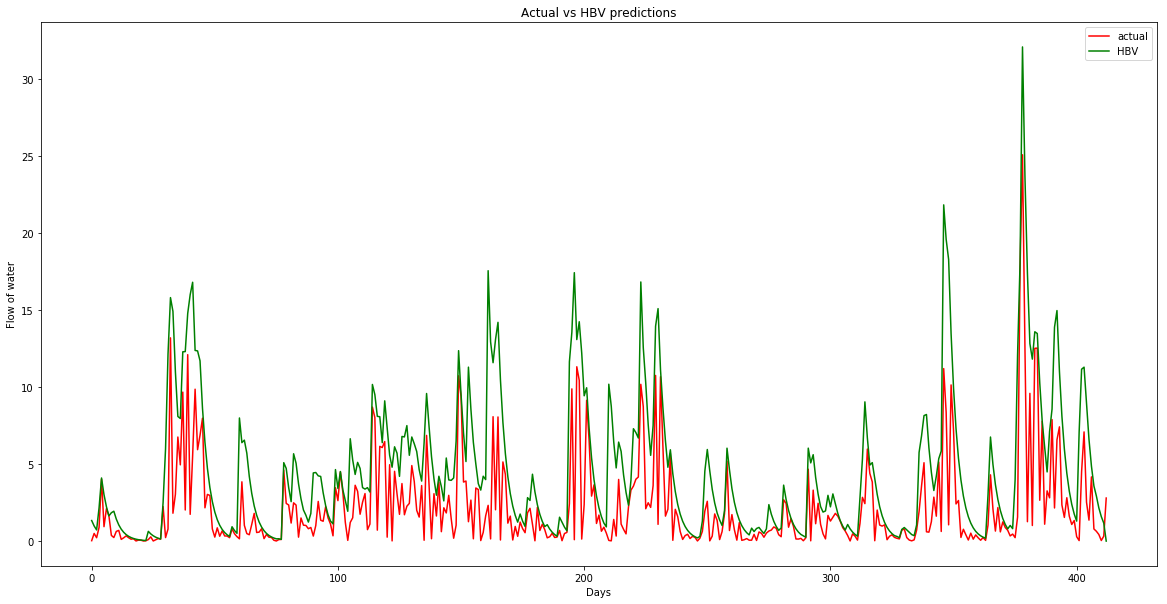

In [82]:
# comparison of actual data and HBV predicted one
plt.figure(figsize=(20,10))
plt.plot(actual[1].values, c='r',label='actual')
plt.plot(a_total, c='g',label='HBV')
#plt.plot(pred[1].values, lw=0.4,c='b',label='TSO')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Flow of water')
plt.title("Actual vs HBV predictions")
plt.savefig(path+'graphs\\actualvshbv.png')
plt.show()

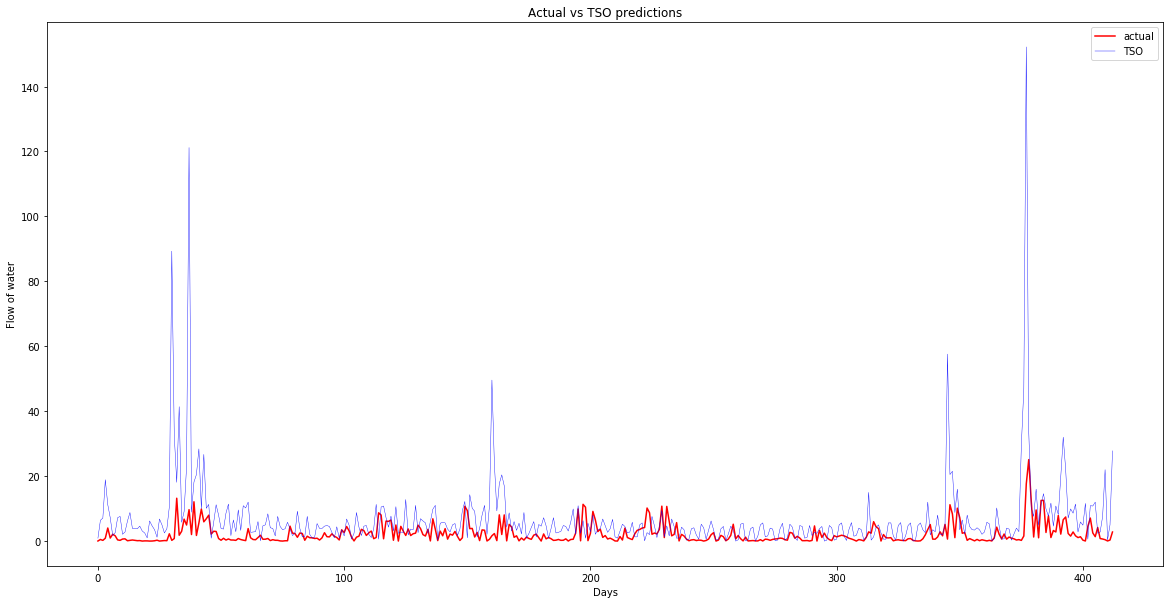

In [83]:
# Actual vs TSO predictions

plt.figure(figsize=(20,10))
plt.plot(actual[1].values, c='r',label='actual')
#plt.plot(a_total, c='g',label='HBV')
plt.plot(pred[1].values, lw=0.4,c='b',label='TSO')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Flow of water')
plt.title("Actual vs TSO predictions")
plt.savefig(path+'graphs\\actualvstso.png')
plt.show()

In [84]:
# Let us look correlation coefficients

print("Correlation with TSO predictions: ",pearsonr(actual_list,pred[1].values)[0])
print("Correlation with HBV predictions: ",pearsonr(actual_list,a_total)[0])

Correlation with TSO predictions:  0.368231432104244
Correlation with HBV predictions:  0.7401717682184332


### 3.2. Optimisation without constraints on daily flows


In [101]:
# HPP parameters
a = pred[1].values[:365]  
T = len(a)                                   # number of days
q0 = np.zeros(T)                             # initial values fo r outflows (L)
s = np.array([100 for i in range(T)])         # spot price
x0 = 0.75 * 137*10e6                         # initial lvl of water in the reservoir ~ 75% full 
h = 0.85                                     # head

# constraints        
qpmax = 18688320*T                           # Max quantity of water flown out from the reservoir over the period, ie no cosntraint here
qpmin = 0                                    # Min quantity of water flown out from the reservoir over the period
xmin = [0.25* 137*10e6 for i in range(T)]    # Daily minimum lvl of water in the reservoir ~ 25% of full
x_max = 137*10e6                             # reservoir water capacity
xmax = [x_max for i in range(T)]

# bounds                 
qmin = [0 for i in range(T)]                 # daily minimum of water flown out from the reservoir
qmax = [18688320  for i in range(T)]         # daily minimum of water flown out from the reservoir

b = [(qmin[t],qmax[t]) for t in range(T)]    # bounds using the above

#### 3.2.1. Using TSO predictions

In [102]:
# Optimization using TSO predictions

a = pred[1].values[:365]                                 # inflows in the reservoir (L)
solution = HPP(q0,b,cons) 

Payoff is : 110980955.75


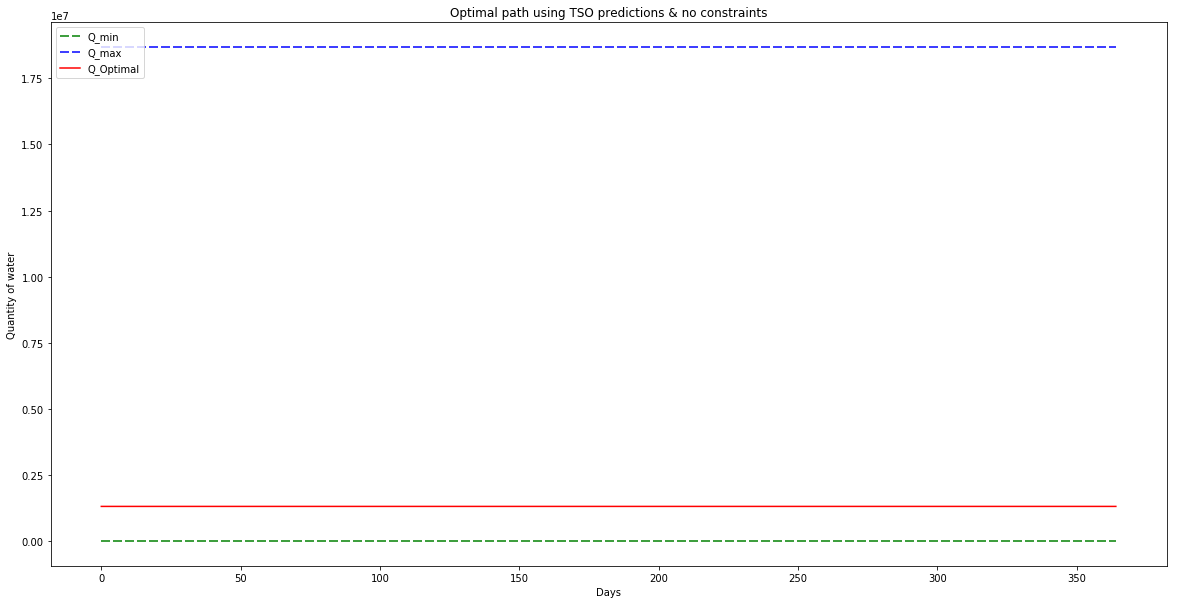

In [103]:
# Graph of the optimal path using TSO predictions

plt.figure(figsize=(20,10))
plt.plot(qmin, c='g', label='Q_min',dashes=[6, 2])
plt.plot(qmax, c='b', label='Q_max',dashes=[6, 2])
plt.plot(solution.x, c='r',label='Q_Optimal')
plt.legend(loc='upper left')
plt.title("Optimal path using TSO predictions & no constraints")
plt.xlabel("Days")
plt.ylabel("Quantity of water")
plt.savefig(path+'graphs\\optimal_path_tso_noconstraints.png')
plt.show()

#### 3.2.2. Using HBV predictions



In [104]:
# optimization using HBV predictions

a = a_total[:365] 
solution = HPP(q0,b,cons) 


Payoff is : 71585888.27


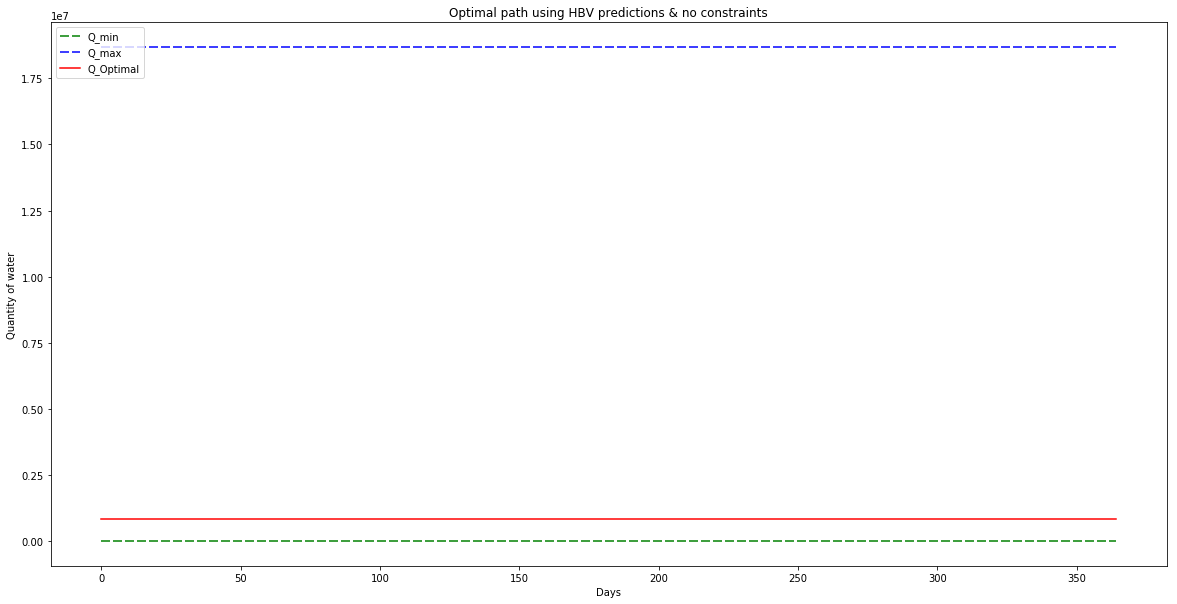

In [105]:
# Graph of the optimal path using HBV predictions

plt.figure(figsize=(20,10))
plt.plot(qmin, c='g', label='Q_min',dashes=[6, 2])
plt.plot(qmax, c='b', label='Q_max',dashes=[6, 2])
plt.plot(solution.x, c='r',label='Q_Optimal')
plt.legend(loc='upper left')
plt.title("Optimal path using HBV predictions & no constraints")
plt.xlabel("Days")
plt.ylabel("Quantity of water")
plt.savefig(path+'graphs\\optimal_path_hbv_noconstraints.png')
plt.show()

### 3.3. Optimisation with constraints on daily flows

In [110]:
# HPP parameters

T = len(a)                                   # number of days
q0 = np.zeros(T)                             # initial values fo r outflows (L)
s = np.array([100 for i in range(T)])         # spot price
x0 = 0.75 * 137*10e6                         # initial lvl of water in the reservoir ~ 75% full 
h = 0.85                                     # head

# constraints        
qpmax = 18688320*T                           # Max quantity of water flown out from the reservoir over the period, ie no cosntraint here
qpmin = 0                                    # Min quantity of water flown out from the reservoir over the period
xmin = [0.25* 137*10e6 for i in range(T)]    # Daily minimum lvl of water in the reservoir ~ 25% of full
x_max = 137*10e6                             # reservoir water capacity
xmax = [x_max for i in range(T)]

# bounds                 

# daily minimum of water flown out from the reservoir
qmin = [0.01*qpmax/T for i in range(int(T/2)+1)]  +[0.05*qpmax/T for i in range(int(T/4))]+[0 for i in range(int(T/4))]              
# daily minimum of water flown out from the reservoir
qmax = [18688320*0.75  for i in range(int(T/2)+1)]  + [18688320*0.5  for i in range(int(T/4))]  +[18688320*0.65  for i in range(int(T/4))]        

b = [(qmin[t],qmax[t]) for t in range(T)]    # bounds using the above

#### 3.3.1. Using TSO predictions


In [111]:
# Optimization using TSO predictions

a = pred[1].values[:365]                                 # inflows in the reservoir (L)
solution = HPP(q0,b,cons) 

Payoff is : 85433467.67


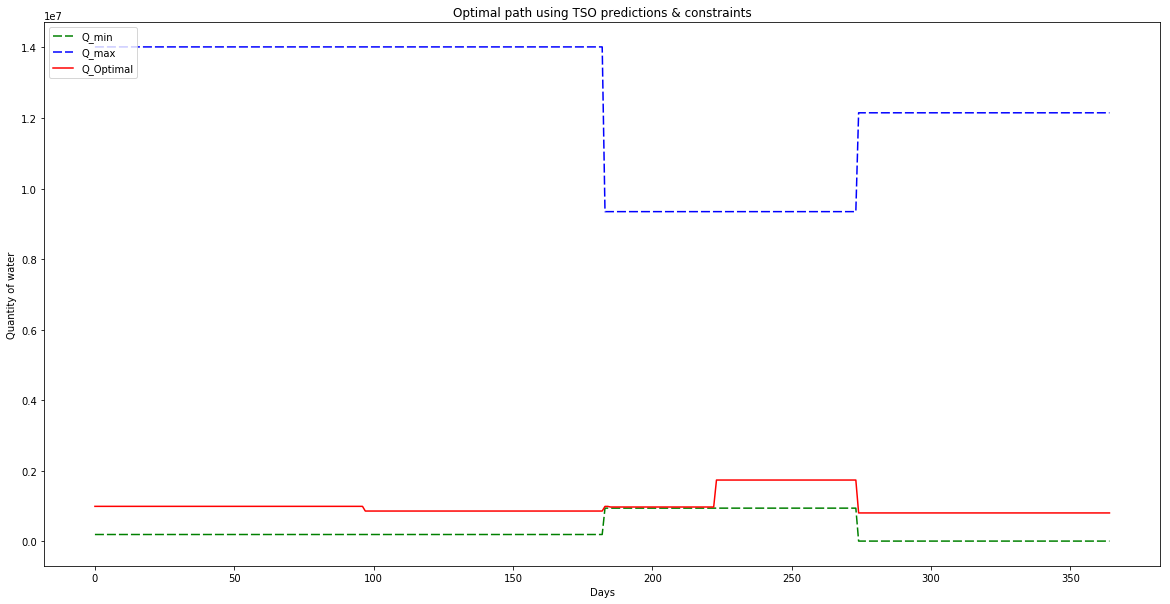

In [112]:
# Graph of the optimal path using TSO predictions

plt.figure(figsize=(20,10))
plt.plot(qmin, c='g', label='Q_min',dashes=[6, 2])
plt.plot(qmax, c='b', label='Q_max',dashes=[6, 2])
plt.plot(solution.x, c='r',label='Q_Optimal')
plt.legend(loc='upper left')
plt.title("Optimal path using TSO predictions & constraints")
plt.xlabel("Days")
plt.ylabel("Quantity of water")
plt.savefig(path+'graphs\\optimal_path_tso_constraints.png')
plt.show()


#### 3.3.2. Using HBV predictions

In [113]:
# optimization using HBV predictions

a = a_total[:365] 
solution = HPP(q0,b,cons) 


Payoff is : 158790211.51


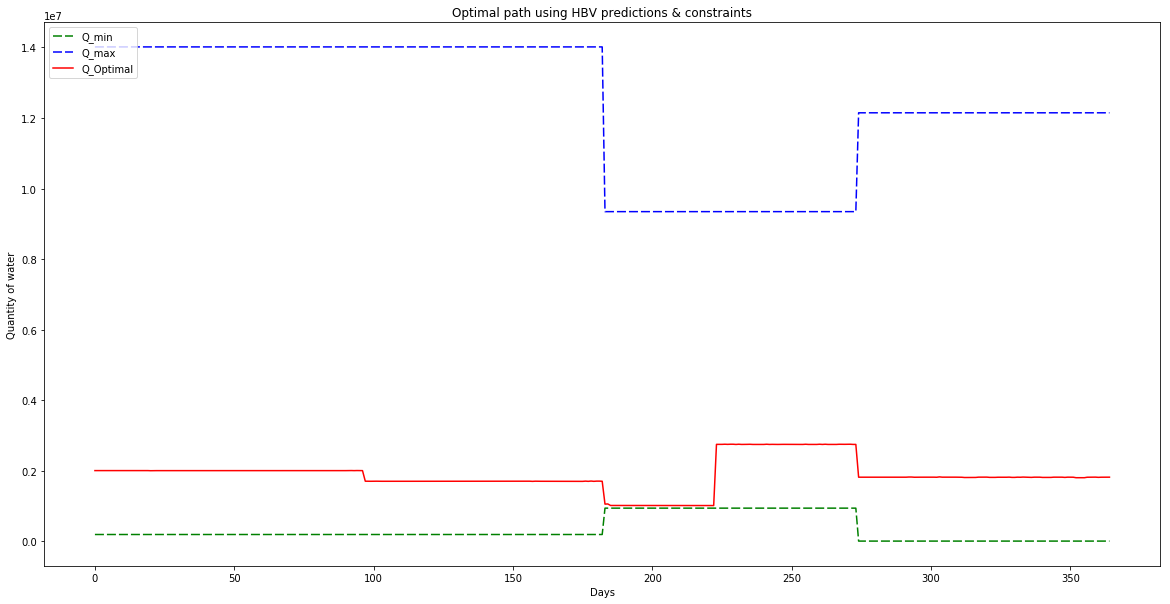

In [114]:
# Graph of the optimal path using HBV predictions

plt.figure(figsize=(20,10))
plt.plot(qmin, c='g', label='Q_min',dashes=[6, 2])
plt.plot(qmax, c='b', label='Q_max',dashes=[6, 2])
plt.plot(solution.x, c='r',label='Q_Optimal')
plt.legend(loc='upper left')
plt.title("Optimal path using HBV predictions & constraints")
plt.xlabel("Days")
plt.ylabel("Quantity of water")
plt.savefig(path+'graphs\\optimal_path_hbv_constraints.png')
plt.show()